In [1]:
# Fill in your name using the format below and student ID number
your_name = "van Breukelen, Sterre"
student_id = "1013957"

In [2]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = True

In [3]:
# Uncomment the following line to run in Google Colab
# !pip install --quiet openml 

In [4]:
# Uncomment the following line to run in Google Colab
#%tensorflow_version 2.x
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [6]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))

Hi Sterre, Looks good. You may continue :)


# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [7]:
#base_dir = '/content/drive/My Drive/TestAssignment' # For Google Colab
base_dir = './'

In [8]:
#Uncomment to link Colab notebook to Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [9]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
#import os
#oml.config.cache_directory = os.path.expanduser('/content/cache')

In [10]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

Reshape, sample and split the data

In [11]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255.
yr = to_categorical(y)

In [12]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

Check the formatting - and what the data looks like

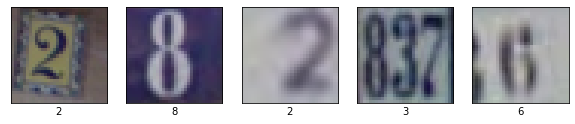

In [13]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n], cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,len(X_train)) for i in range(5)]
X_random = [X_train[i] for i in images]
y_random = [y_train[i] for i in images]
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [14]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    try:
        model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    model.save(os.path.join(base_dir, name+extension))

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        shout("Loading model from file", verbose)
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
        return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
        return
        shout("Success!", verbose)
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

In [15]:
# Toy usage example
# Remove before submission
# from tensorflow.keras import models
# from tensorflow.keras import layers 

# def build_toy_model():
#     model = models.Sequential()
#     model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
#     model.add(layers.Dense(10, activation='relu'))
#     model.add(layers.Dense(10, activation='softmax'))
#     model.compile(optimizer='rmsprop',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model

# # First build and store
# run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, 
#                train=True, epochs=3, batch_size=32)

In [16]:
# Toy usage example
# Remove before submission
# With train=False: load from file and report the same results without rerunning
# run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, 
#                train=False)

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

In [17]:
from tensorflow.keras import models
from tensorflow.keras import layers 

def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))

#     73 with overfitting
    model.add(layers.Dense(640, activation='relu'))
    model.add(layers.Dense(160, activation='relu'))
    model.add(layers.Dense(40, activation='relu'))
    model.add(layers.Dense(10, activation='sigmoid'))

    
    
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir,train=True, epochs=13, batch_size=64)
answer_q_1_1 = """
First the nodes and layers were increased. 
Different values for nodes were tried, double/triple/quadruple the number of nodes from the bottom up. 
Quadruple with four layers works best.

Different activations were tried, relu performed better then elu and selu. Sigmoid performed better then softmax and softplus. 
Having the last layer with activation sigmoid worked best then any other combo.
Lastly, I finetuned the epochs to reduce overfitting, the model still overfits slightly
               """
print("Answer is {} characters long".format(len(answer_q_1_1)))

Loading model from file
Answer is 500 characters long


### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [18]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

In [19]:
# Replace with the preprocessed data
preprocessed_split = rgb2gray(X_train), rgb2gray(X_val), y_train, y_val

# Adjusted model
def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))

    model.add(layers.Dense(640, activation='relu'))
    model.add(layers.Dense(160, activation='relu'))
    model.add(layers.Dense(40, activation='relu'))
    model.add(layers.Dense(10, activation='sigmoid'))
    
   
    
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=True, epochs=13, batch_size=64)

answer_q_1_2 = """
I greyscaled X_training and X_val and I changed the Reshape to be on dimention 32x32x1, as this is the new shape the images have come in.
The model performs slightly better, because the color of the images is not taken into account when classifying the numbers, as color isn't important in the classification.
However, the accuracy difference between 1.2 and 1.1 is minimal.
               """
print("Answer is {} characters long".format(len(answer_q_1_2)))

Loading model from file
Answer is 391 characters long


### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

In [20]:
from tensorflow.keras import regularizers, optimizers

def build_model_1_3():
    model = models.Sequential()
   
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))

    model.add(layers.Dense(640, 
                           activation='relu', 
                            bias_regularizer=regularizers.l2(0.1), 
                          ))
    
    model.add(layers.Dense(160,
                           activation='relu',
                           bias_regularizer=regularizers.l2(0.01), 
                           
                          ))
    
    
    model.add(layers.Dense(40, 
                           activation='relu',
                           bias_regularizer=regularizers.l2(0.001), 
                           
                          ))
    
    model.add(layers.Dense(10, 
                           activation='sigmoid',
                           bias_regularizer=regularizers.l2(0.0001), 
                           activity_regularizer=regularizers.l2(0.0005)
#                            
                          ))
    
   
    
    model.compile(
        optimizers.Nadam(learning_rate=0.0004),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
    )
    

    
    return model
  
run_evaluation("model_1_3", build_model_1_3, preprocessed_split, base_dir, 
               train=True, epochs=9, batch_size=64)
answer_q_1_3 = """
I tried kernel, bias and activity regularizers for l1 and l2, for values from 1 to 0.0001. 
The one combo chosen was the one with the highest accuracy and the lowest overfitting.
I tried RMSprop,SGD, Adadelta, Adam, Adamax, and Nada optimizers with the values of 1 to 0.0001 as learning rate.
Nadam optimizer performed the best out of all the others with learning rate 0.0001.
Lastly I finetuned the epochs and the batch size. The model starts to overfit at more epochs. 

               """
print("Answer is {} characters long".format(len(answer_q_1_3)))

Loading model from file
Answer is 489 characters long


## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

In [21]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers, optimizers


def build_model_2_1():
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',  input_shape=(32, 32, 1) ))  
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', ))
    
    model.add(layers.UpSampling2D(size=(1, 1), data_format=None, interpolation='nearest') )
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',  ))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',  ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Dropout(0.2))   
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',   ))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',  ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu',  
                           bias_regularizer=regularizers.l2(0.001),
                           activity_regularizer=regularizers.l2(0.1) ))
    model.add(layers.Dense(10, activation='sigmoid',
                           bias_regularizer=regularizers.l2(0.001),
                           activity_regularizer=regularizers.l2(0.1)))
    
    model.compile(optimizers.Nadam(learning_rate=0.0003),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=True, epochs=6, batch_size=64)
answer_q_2_1 = """
Several convolutional layers were tried in several combos, like Conv2D, Cropping2D, and UpSampling2D.
Conv2D layers were added with increasing value of filters to learn the patterns on different levels of abstraction.
MaxPooling was added inbetween the conv2D layers to reduce the resolution and increase the translation.
More conv2D layers were added, in groups of one, two and three and groups of two gave the best accuracy.
The same was tried with MaxPooling and one layer gave the best accuracy. 
Dropout as added in several different places with several different values. The combo chosen gave the best accuracy. 
A layer of UpSampling2D in its current position increased the accuracy. The other types of layers decreased the accuracy. 
Lastly the hyperparameters were tuned
               """
print("Answer is {} characters long".format(len(answer_q_2_1)))

Loading model from file
Answer is 796 characters long


### Question 2.2: Data Augmentation (3 points)


- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

In [22]:
# Note that we build the same untrained model as in question 2.1 but store the 
# trained version as model_2_2. Change attributes as needed to run on augmented
# data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=0.10, 
)

augmented_split = train_datagen.flow(preprocessed_split[0], preprocessed_split[2], batch_size=64) ##x_test, x_val

run_evaluation("model_2_2", build_model_2_1, (augmented_split,  preprocessed_split[1], y_val), base_dir, 
               train=True,  generator=True, epochs=100, batch_size=None)
answer_q_2_2 = """
Several setting for imageDataGenerator were tried, but most didn't help the accuracy or overfitting.
The rotation range, gave the best reduction in overfitting when the value was low, so not over 0.10
The accuracy went down when using horizontal and vertical flip. Also with Brightness_range, the shifts, and zoom range.
When using shear_range the overfitting went up slightly. 
Overal the accuracy hasn't increased, but there is a lot less overfitting.
               """
print("Answer is {} characters long".format(len(answer_q_2_2)))

Loading model from file
Answer is 470 characters long


## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

19858/19858 [==============================] - 3s 166us/sample - loss: 0.3892 - accuracy: 0.9439


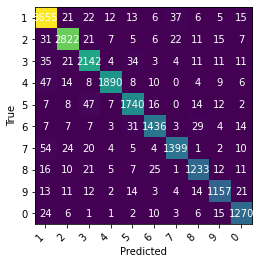

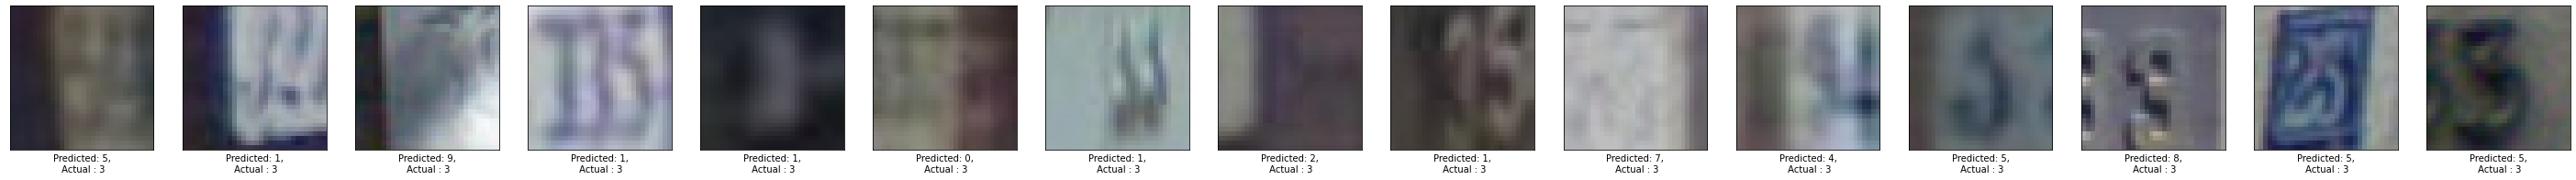

Answer is 825 characters long


In [23]:
from sklearn.metrics import confusion_matrix

#Load the model
model_2_2 = load_model_from_file(base_dir=base_dir, name="model_2_2")

#evaluate the model with test data
test_accuracy_3_1 = model_2_2.evaluate(rgb2gray(X_test), y_test)
#predict the model on the test data
y_pred = model_2_2.predict(rgb2gray(X_test))
#the classes
digits = ['1','2','3','4','5','6','7','8','9','0']

def plot_confusion_matrix():
    matrix = confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
    fig, ax = plt.subplots()
    im = ax.imshow(matrix)
    
    ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
    
    ax.set_xticklabels(digits, 
                       rotation=45, 
                       ha="right")
    ax.set_yticklabels(digits)
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    
    for i in range(100):
        ax.text(
            int(i/10), i%10, matrix[i%10,int(i/10)], 
            ha="center", 
            va="center", 
            color="w"
        )
    
def plot_misclassifications():
    misclass = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]
    fig, ax = plt.subplots(1, 15,  figsize=(50, 50))

    for n, i in enumerate(
        [j for j in misclass if ((np.argmax(y_test[j])+1)%10) == 3][0:15]
    ):
        ax[n].imshow(X_test[i])
        ax[n].set_xlabel(f"Predicted: {(np.argmax(y_pred[i])+1)%10},\n Actual : {(np.argmax(y_test[i])+1)%10}")                   
        ax[n].set_xticks(()), ax[n].set_yticks(())

    plt.show();
    
plot_confusion_matrix()
plot_misclassifications()
    
answer_q_3_1 = """
50 images were compaired, only fifteen were printed in the final version for readability
The classes that are often confused are 5 and 3, 7 and 1, 1 and 4.
5 and 3 is most likely confused because the lower halves are the same.
7 and 1, and 1 and 4 probably gets confused, because all numbers have straight lines.
I visualize the misclassifications of class 3. 
A lot of missclassification is caused by noisiness and blurriness, so part of the numberr gets lost and it gets missclassified.
Another missclassification is caused by rotation. 
It then gets confused for a 4 if it is rotated to the left and as a 2 if rotated to the right
Also there are missclassification when the 3 is denoted slightly different. 
For instance, if the upper half isn't a half circle but straight lines, it gets confused for a 5.
               """
print("Answer is {} characters long".format(len(answer_q_3_1)))

### Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

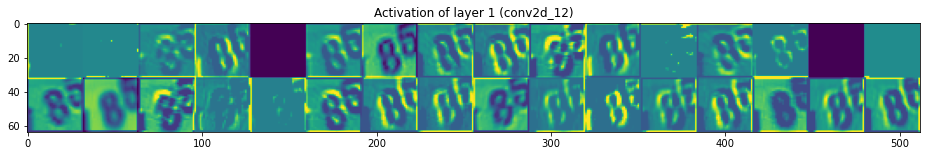

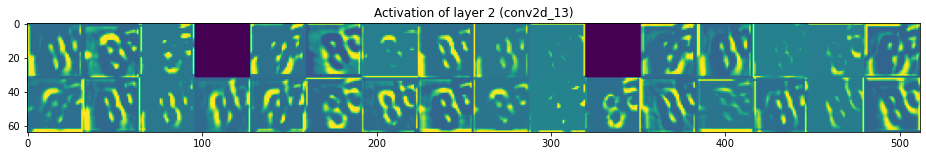

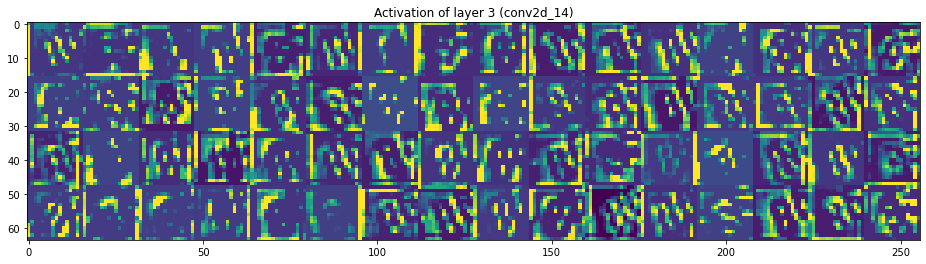

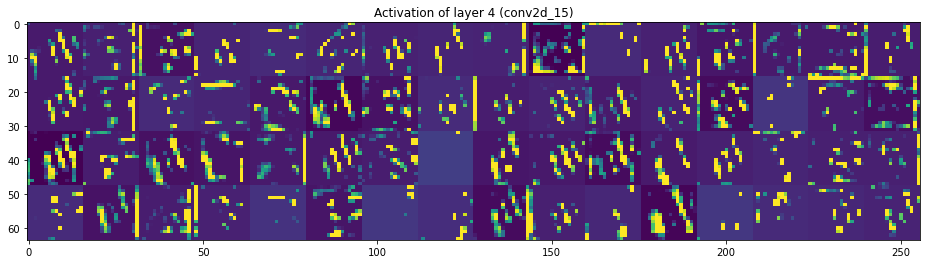

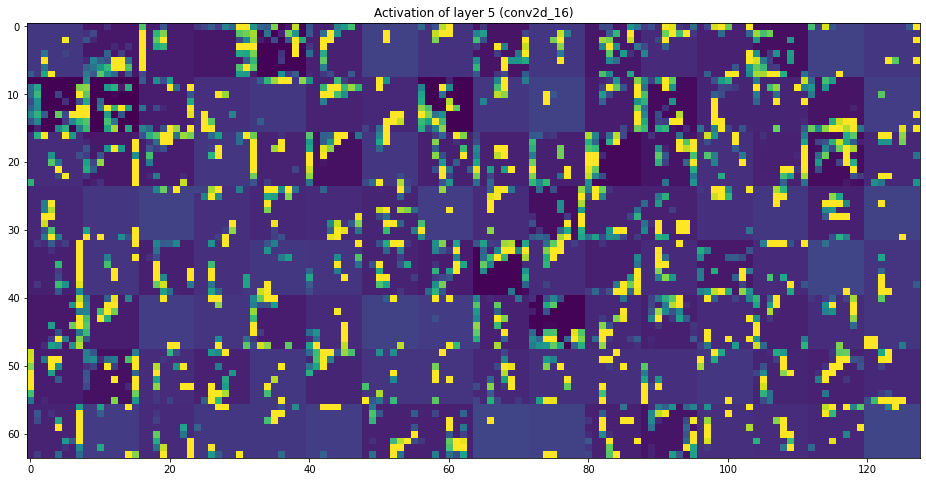

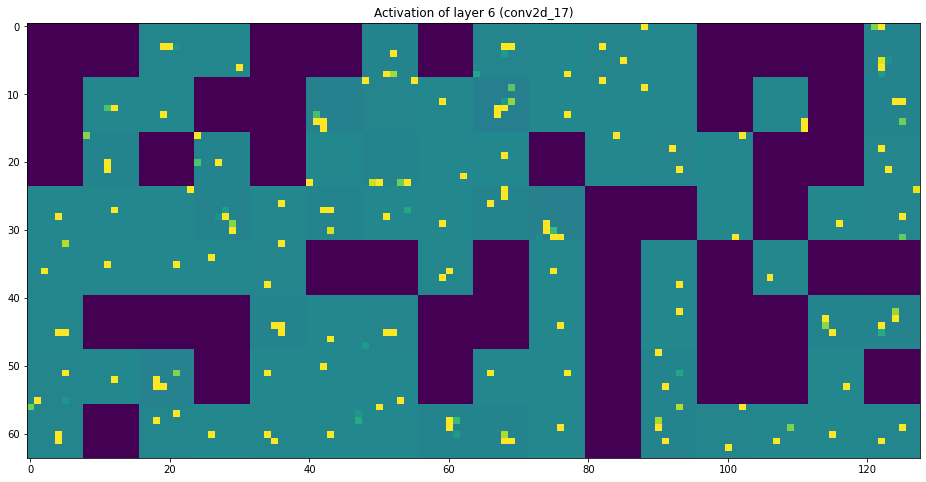

Answer is 686 characters long


In [24]:
from tensorflow.keras import models


def plot_activations():
    model_2_2 = load_model_from_file(base_dir=base_dir, name="model_2_2") #model_2_2 loaded
    grey_X = rgb2gray(X_test)
    
    img = grey_X[0]
    img = np.expand_dims(img, axis=0) 
    

    layer_outputs = [layer.output for layer in model_2_2.layers[:len(model_2_2.layers)] if 'conv2d' in layer.name]
    activation_model = models.Model(inputs=model_2_2.input, outputs=layer_outputs)
    
    activations = activation_model.predict(img)
    
    images_per_row = 16

    layer_names = []
    for layer in model_2_2.layers[:len(model_2_2.layers)] :
        if 'conv2d' in layer.name :
            layer_names.append(layer.name)

    for i in range(len(layer_names)) :
        start = i
        end = i+1
        # to display the feature maps
        for layer_name, layer_activation in zip(layer_names[start:end], activations[start:end]):
            # This is the number of features in the feature map
            n_features = layer_activation.shape[-1]

            # The feature map has shape (1, size, size, n_features)
            size = layer_activation.shape[1]

            # We will tile the activation channels in this matrix
            n_cols = n_features // images_per_row
            display_grid = np.zeros((size * n_cols, images_per_row * size))

            # We'll tile each filter into this big horizontal grid
            for col in range(n_cols):
                for row in range(images_per_row):
                    channel_image = layer_activation[0, :, :, col * images_per_row + row]
                    # Post-process the feature to make it visually palatable
                    channel_image -= channel_image.mean()
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                    display_grid[col * size : (col + 1) * size,
                                 row * size : (row + 1) * size] = channel_image

            # Display the grid
            scale = 1. / size
            plt.figure(figsize=(scale * display_grid.shape[1],
                                scale * display_grid.shape[0]))
            plt.title("Activation of layer {} ({})".format(i+1,layer_name))
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()
np.seterr(divide='ignore', invalid='ignore')
plot_activations()

answer_q_3_2 = """
The most interesting layers to view are the conv2d layers. After the third layer, the layers become more abstract and there isn't much infrmation to be gathered.
In the first two layers there is various edge detecting. Such as the edges around th eight and five.
Layer 3 already shws amore abstract images, but the 8 is often still recognisable. 
After that the images beccome more abstract, however layer 4 still shows a pattern of three lines. 
In layer 5 this pattern is no longer vissable and the images seem to not have a clear pattern and are very abstact. 
Layer 6, are only a scattering of dots, so it seemms like the model is no longer learning anything useful
               """
print("Answer is {} characters long".format(len(answer_q_3_2)))

### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpossible the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Predicted: 8


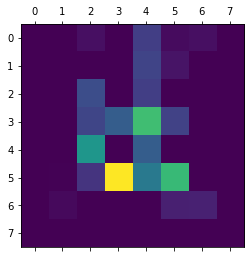

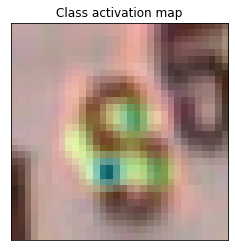

In [25]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import cv2


def plot_activation_map():
    #needed to be added to run k.gradient
    tf.compat.v1.disable_eager_execution()  

    #load the model from 2.2
    model =  load_model_from_file(base_dir=base_dir, name="model_2_2")
    #we need a graph to get solve of a error tat only occured when you first run the cell
    graph = tf.compat.v1.get_default_graph()
    
    #get img and modify it so it can be used
    x = X_test[0]
    x = np.expand_dims(x, axis=0)
    x = rgb2gray(x)
    
    output = model.output
    last_conv_layer = model.get_layer('conv2d_17')
    grads = K.gradients(output, last_conv_layer.output)[0]
    
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    
    pooled_grads_value, conv_layer_output_value = iterate([x])

    for i in range(128):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    
    #get prediction using the graph
    with graph.as_default():
        preds = model.predict(x)
        print('Predicted:', (np.argmax(preds)+1)%10)
        
    #create heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    plt.matshow(heatmap)
    plt.show()
    
    return heatmap

def plot_3_3():
    #get img and add colour to the img
    img = X_test[0]
    img = np.uint8(255 * img)
    
    #get heatmap, resize the heatmap and modify the colour
    heatmap = plot_activation_map()
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * 0.4 + RGB_img

    #safe the model and read themodel
    cv2.imwrite('../imposed_img.jpg', superimposed_img)
    superimposed = cv2.imread('../imposed_img.jpg')

    #make the superim
    plt.imshow(superimposed)
    plt.title('Class activation map')
    plt.xticks([])
    plt.yticks([])
    plt.show()

plot_3_3()


## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

In [26]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import regularizers, optimizers

def build_model_4_1():
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    model = models.Sequential()
    model.add(conv_base)

    
    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            conv_base.trainable = True
        else:
            conv_base.trainable = False
            
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(10, activation='sigmoid'))

    model.compile(
        optimizer=optimizers.RMSprop(),
#         optimizers.SGD(learning_rate=0.001),
#         optimizers.Adadelta(learning_rate=0.0008),
#          optimizers.Adam(learning_rate=0.001),
#                 optimizers.Adamax(learning_rate=0.0005),
#         optimizers.Nadam(learning_rate=0.005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
    
run_evaluation("model_4_1", build_model_4_1, evaluation_split, base_dir, 
               train=True, epochs=8, batch_size=32)
answer_q_4_1 = """
For freezing several things were tried. The entire conv_base was freezed, up to the last three blocks were unfrozen. 
Unfreezing the last blocks worked best, however, there wasn't a difference seen between unfreezing the last one, two or three blocks, so only the last block was not freezed.
Different optimizers were tried and RMSprop with default learning rate performed best.
The accuracy of the model is arround 60%, however there is some overfitting. 
               """
print("Answer is {} characters long".format(len(answer_q_4_1)))

Loading model from file
Answer is 473 characters long


### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [27]:
import pickle
import gzip
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR, SVC
from sklearn.model_selection import cross_val_score


def store_embedding(X, name):  
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
        pickle.dump(X, file_pi)

def load_embedding(name):
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
        return pickle.load(file_pi)

def store_embeddings():
    """ Stores all necessary embeddings to file
    """

    model = load_model_from_file(base_dir=base_dir, name="model_4_1") 
    conv_base =  model.get_layer('vgg16')

    
    embed_train = conv_base.predict(X_train)
    embed_test = conv_base.predict(X_test)
  

    store_embedding(embed_train, 'train')
    store_embedding(embed_test, 'test')

def generate_pipeline():
    """ Returns an sklearn pipeline.
    """
    regressor = LinearRegression()

#     cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(sparse=False, handle_unknown='ignore'))
#     num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
#     transform = make_column_transformer((num_pipe, X_val))
#     return Pipeline(steps=[('preprocess', transform), ('reg', regressor)])
    return Pipeline( [('regressor', regressor)])

def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
    """ Evaluates the given pipeline, trained on the given embedded training set and 
      evaluated on the supplied embedded test set. Returns the accuracy score.
    """ 
    regressor = LinearRegression()
    
    print("start fitting on train")
    pipeline.fit(X_train, y_train)
    print("cross validate train")
    scores_train = cross_val_score(pipeline, X_train, y_train)
#     print("Cross-validated R^2 score for {} on training data: {:.2f}".format(regressor.__class__.__name__, scores_train.mean()))
   
    print("start fittin on test")
    pipeline.fit(X_test, y_test)
    print("cross validate test")
    scores_test = cross_val_score(pipeline, X_test, y_test)
#     print("Cross-validated R^2 score for {} on test data: {:.2f}".format(regressor.__class__.__name__, scores_test.mean()))
    return scores_train.mean(), scores_test.mean()
    
def evaluation_4_2(X_train, y_train, X_test, y_test):
    """ Runs 'evaluate_pipeline' with embedded versions of the input data 
      and returns the accuracy.
    """
    pipe = generate_pipeline()
    
    #reshape data
    X_tr  = load_embedding('train')
    X_tr = np.reshape(X_tr, (X_tr.shape[0], X_tr.shape[3])).astype('float32')  

    X_te = load_embedding('test')
    X_te = np.reshape(X_te, (X_te.shape[0],X_te.shape[3])).astype('float32')
    
    y_tr = np.argmax(y_train, axis=1).astype('float32')
    y_te = np.argmax(y_test, axis=1).astype('float32')
    
   
    return evaluate_pipeline(pipe, X_tr, y_tr , X_te, y_te )


answer_q_4_2 = """
Some regressors were tried. Linear gave an accuracy of about 30%, Ridge and lasso were worse.  
RandomForest and GradientBoosting took a about an hour to run, and had an accuracy of about 32-37
SVR, gave a similair accuracy. Yet it took over three hours to run, so it was decided to continue with linear,
as it gives a similair accuracy but quicker.
Due to time restrictions, the accuracy I settled for was 34 for training data and 33 for the test data.
This is not better then the other models.
"""
print("Pipeline:",generate_pipeline())
print("Answer is {} characters long".format(len(answer_q_4_2)))

# store_embeddings()
train_ac, test_ac = evaluation_4_2(X_train, y_train, X_test, y_test)
print("accuracy on train data: {:.2f}".format( train_ac))
print("accuracy on test data: {:.2f}".format(test_ac))
   

Pipeline: Pipeline(memory=None,
         steps=[('regressor',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
Answer is 497 characters long
start fitting on train
cross validate train
start fittin on test
cross validate test
accuracy on train data: 0.34
accuracy on test data: 0.33
